It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
dataset = dataset['train']
class_names = ['cat', 'dog']

size = tf.data.experimental.cardinality(dataset).numpy()
print(f'number of images:{size}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteD7UT9L/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
number of images:23262


We need all images to be the same size, we can use [`resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize):

```python
tf.image.resize(
    images, size, method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
```


[Tensorflow tf.data.Dataset tutorial](https://www.tensorflow.org/guide/data)

In [25]:
image_size = (96, 96, 3)


def preprocess_img(images, size=(96, 96)):
    return tf.image.resize(images, size)

dataset = dataset.map(lambda images, labels: (preprocess_img(images), labels))

Split the dataset, you can use [different techniques](https://www.tensorflow.org/datasets/splits)

In [40]:
batch_size = 32
train_size = int(0.75 * size)
val_size = int(0.1 * size)

train_ds = dataset.take(train_size)
train_ds = train_ds.shuffle(1000).batch(batch_size).cache()
remaining = dataset.skip(train_size)

val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

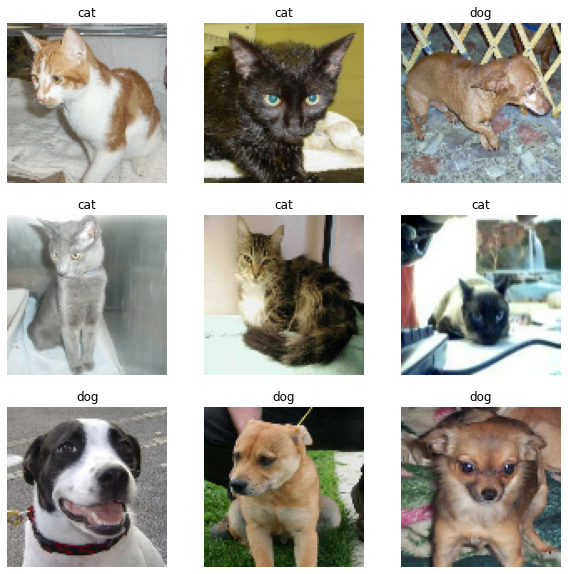

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# CNN model

You can visit the tutorial [Introduction_to_CNN](https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/Introduction_to_CNN.ipynb)

## CNN model in Keras



<img src="https://i.ibb.co/D8CmT6K/cnn.jpg" alt="cnn" border="0">



A Convolutional Neural Network (CNN) architecture has four main parts:

- A **convolutional layer** that extracts features from a source image. 

- A **pooling layer** that reduces the image dimensionality without losing important features or patterns.

- A **flattening layer** that transforms a n-dimensional tensor into a vector that can be fed into a fully connected neural network.

- A **fully connected layer** also known as the dense layer.

### Rescaling

For converting the images to   \[0,1\] range.
```python
normalization_layer = layers.Rescaling(1./255)
next_layer = normalization_layer(prev_layer)
```
or simply
```python
reescaling = layers.Rescaling(1. / 255)(inputs)
```

### Convolutional layer

In the convolutional layers (`Conv2D`) we will configure the following parameters:

- **filters**: number of feature maps.
- **kernel_size**: can be either an integer or a tuple of two integers. Specifies the height and width of the kernel.
- **padding**: allows you to include padding in the input data. With 'valid' it is not applied, with 'same' it is configured so that the dimension at the output of the convolution is the same as at the input.
- **activation**: activation function implemented. Recommended ReLU.

[Link to documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    activation=None, kernel_regularizer=None)

```

With Functional API:
```python
next_layer = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)
```

With Sequential:
```python
model.add(layers.Conv2D(filters=8,kernel_size=3, activation='relu', name='conv_1'))
```

### Pooling layer

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity ( ReLU) you can choose between [average pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [max pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Usually max pooling is the best choice.


With Functional API:
```python
conv_1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)

pool_1 = layers.MaxPool2D(pool_size=(2, 2), name='pool_1')(conv_1)
```

With Sequential:
```python
model.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_1'))
```

### Flattening

Prepares a vector for the fully connected layers.

With Functional API:

```python
next_layer = layers.Flatten(name='flatten')(prev_layer)
```

With Sequential:
```python
model.add(layers.Flatten(name='flatten'))
```

There is another alternative for flattening that is a type of pooling that is called global pooling. Global pooling down-samples the entire feature map to a single value. 

You can also choose between [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and [GlobalMaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

```python
model.add(layers.GlobalMaxPool2D(name='GlobalMaxPooling2D'))
```

### Fully-connected layer

Dense layer like a simple neural network

## Question 1: Create a model with two convolutional layers without pooling and without any regularization

In [43]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)
# Conv Layer 1
conv_1 = layers.Conv2D(16,3,activation='relu', name='conv_1')(reescaling)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, activation='relu', name='conv_2')(conv_1)


# Fully-connected
# Flattening

flat = layers.Flatten(name='flatten')(conv_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [44]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,  
    verbose=1)



In [46]:
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks = [es_callback]
)

Epoch 1/8
546/546 [==============================] - 37s 66ms/step - loss: 0.5675 - accuracy: 0.7136 - val_loss: 0.5785 - val_accuracy: 0.7077
Epoch 2/8
546/546 [==============================] - 7s 12ms/step - loss: 0.4014 - accuracy: 0.8184 - val_loss: 0.5959 - val_accuracy: 0.7003
Epoch 3/8
546/546 [==============================] - 6s 11ms/step - loss: 0.2348 - accuracy: 0.9045 - val_loss: 0.8109 - val_accuracy: 0.6836
Epoch 3: early stopping


In [47]:
results = model_1.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 18s 31ms/step - loss: 0.8933 - accuracy: 0.6788
Test Loss: 0.8933051824569702
Test Accuracy: 0.6787965893745422


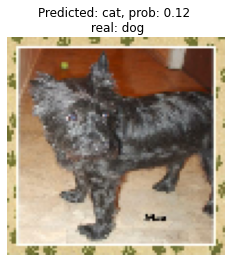

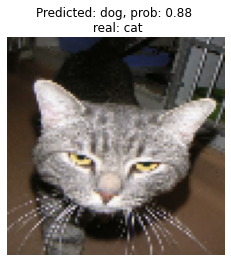

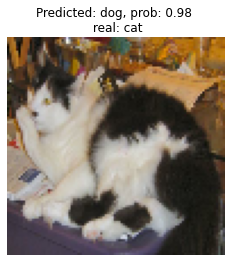

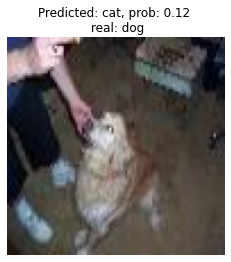

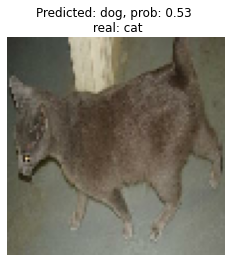

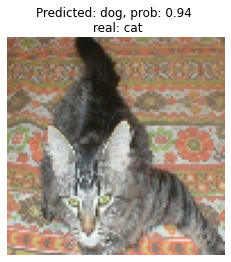

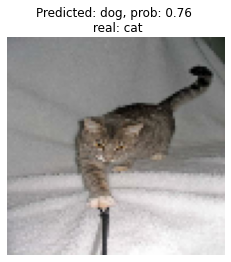

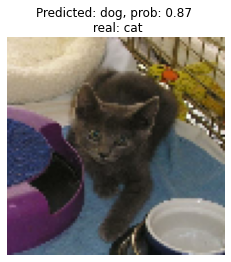

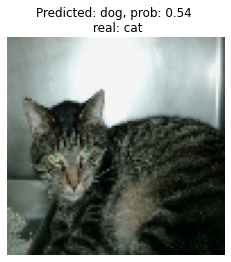

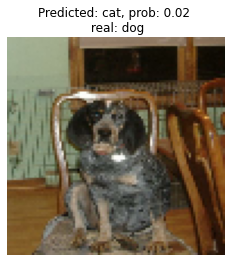

In [48]:
def show_errors(val_ds, model, class_names, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_prob = model.predict(images)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten()
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]
            prob = pred_prob[ind][0]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title('Predicted: {0}, prob: {1:.2f} \n real: {2}'.format(
                pred_class, prob, real_class))
            plt.axis('off')
            plt.show()

            if n_plots == n_images:
                return
    return


show_errors(test_ds, model_1, class_names, n_images=10)

## Question 2: Introduce pooling to the previous model and obtain a better `test_accuracy`, Do not use any regularization

In [49]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1 + pooling
conv_1 = layers.Conv2D(16,3,activation='relu', name='conv_1')(reescaling)

pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
# Conv Layer 2 + pooling
conv_2 = layers.Conv2D(16, 3, activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)



# Fully-connected
# Flattening

flat = layers.Flatten(name='flatten')(pool_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)




In [51]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,  
    verbose=1)

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/8
546/546 [==============================] - 4s 7ms/step - loss: 0.6155 - accuracy: 0.6502 - val_loss: 0.5545 - val_accuracy: 0.7270
Epoch 2/8
546/546 [==============================] - 3s 6ms/step - loss: 0.5114 - accuracy: 0.7473 - val_loss: 0.5052 - val_accuracy: 0.7545
Epoch 3/8
546/546 [==============================] - 3s 6ms/step - loss: 0.4616 - accuracy: 0.7825 - val_loss: 0.4793 - val_accuracy: 0.7726
Epoch 4/8
546/546 [==============================] - 3s 6ms/step - loss: 0.4283 - accuracy: 0.8045 - val_loss: 0.4922 - val_accuracy: 0.7644
Epoch 5/8
546/546 [==============================] - 3s 6ms/step - loss: 0.4015 - accuracy: 0.8182 - val_loss: 0.4882 - val_accuracy: 0.7721
Epoch 5: early stopping


In [52]:
results = model_2.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 0s 4ms/step - loss: 0.4925 - accuracy: 0.7705
Test Loss: 0.49247321486473083
Test Accuracy: 0.7704871296882629


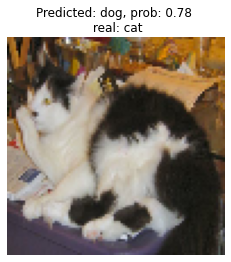

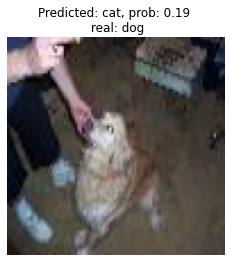

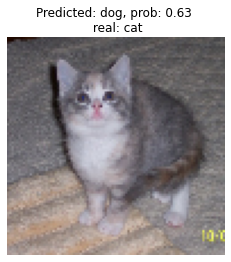

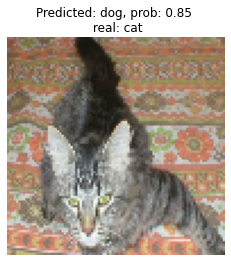

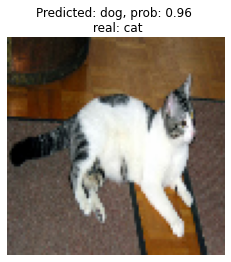

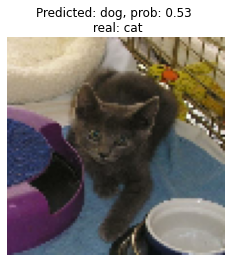

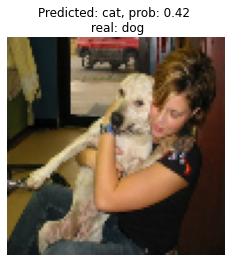

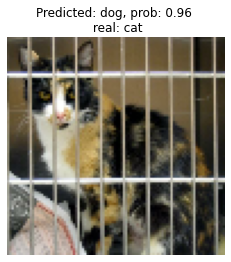

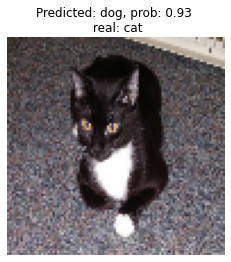

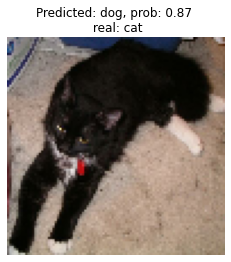

In [54]:
show_errors(test_ds, model_2, class_names, n_images=10)

## Question 3: Introduce regularization (you can try data augmentation) and increase the number of layers to obtain a better `test_accuracy`. Try to obtain `Test Accuracy > 0.8`



In [53]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.25),
  ]
)

In [55]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)


# Conv Layer 1 + pooling
conv_1 = layers.Conv2D(16,3,activation='relu',padding = 'valid', name='conv_1')(reescaling)

pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
# Conv Layer 2 + pooling
conv_2 = layers.Conv2D(16, 3, activation='relu', padding = 'valid',name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Conv Layer 3 + pooling
conv_3 = layers.Conv2D(16, 3, activation='relu', padding = 'valid',name='conv_3')(pool_2)
pool_3 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv_3)


# Fully-connected
# Flattening

flat = layers.Flatten(name='flatten')(pool_3)
drop_1 = layers.Dropout(0.4)(flat)
dense = layers.Dense(64, activation='relu', name='dense')(drop_1)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)


model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)


In [56]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,  
    verbose=1)

history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/8
546/546 [==============================] - 4s 7ms/step - loss: 0.6148 - accuracy: 0.6527 - val_loss: 0.5448 - val_accuracy: 0.7304
Epoch 2/8
546/546 [==============================] - 4s 7ms/step - loss: 0.5331 - accuracy: 0.7331 - val_loss: 0.5041 - val_accuracy: 0.7528
Epoch 3/8
546/546 [==============================] - 4s 7ms/step - loss: 0.4833 - accuracy: 0.7650 - val_loss: 0.4651 - val_accuracy: 0.7928
Epoch 4/8
546/546 [==============================] - 4s 7ms/step - loss: 0.4532 - accuracy: 0.7856 - val_loss: 0.4217 - val_accuracy: 0.8134
Epoch 5/8
546/546 [==============================] - 5s 9ms/step - loss: 0.4291 - accuracy: 0.8016 - val_loss: 0.4389 - val_accuracy: 0.8001
Epoch 6/8
546/546 [==============================] - 4s 7ms/step - loss: 0.4103 - accuracy: 0.8123 - val_loss: 0.4233 - val_accuracy: 0.8100
Epoch 6: early stopping


In [57]:
results = model_3.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 0s 4ms/step - loss: 0.4294 - accuracy: 0.8080
Test Loss: 0.4293976426124573
Test Accuracy: 0.8080229163169861


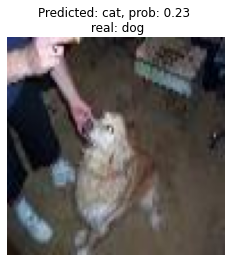

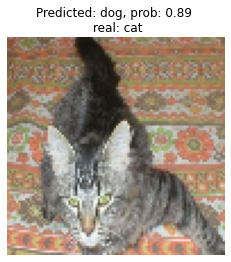

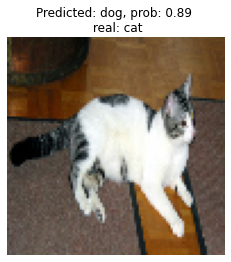

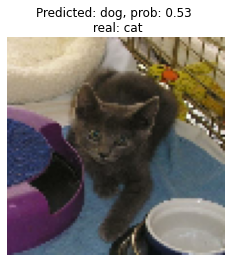

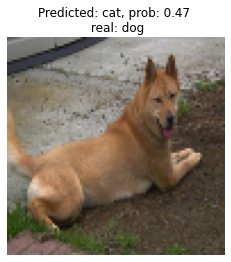

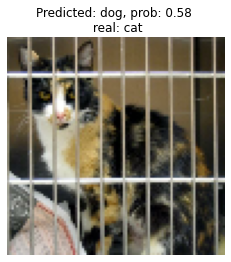

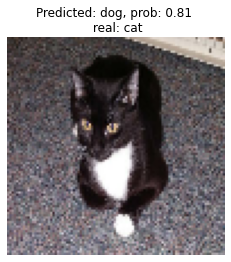

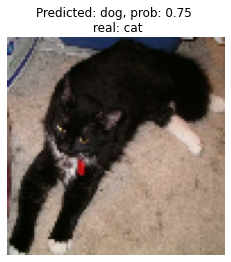

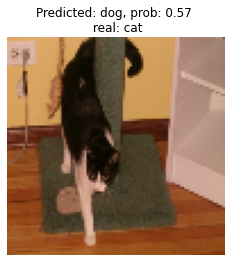

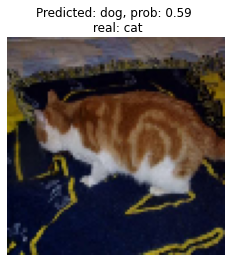

In [58]:
show_errors(test_ds, model_3, class_names, n_images=10)

## Question 4: Try transfer learning

In [59]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size,
                                                     include_top=False)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 1s 0us/step


In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [61]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten(name='flatten')(x)
drop_1 = layers.Dropout(0.4)(flat)
dense_1 = layers.Dense(64, activation='relu', name='dense_1')(drop_1)

outputs = layers.Dense(1, activation='sigmoid', name='output')(dense_1)


model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                           

In [63]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 2

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=2,  
    verbose=1)

history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/2
546/546 [==============================] - 11s 15ms/step - loss: 0.1296 - accuracy: 0.9521 - val_loss: 0.0916 - val_accuracy: 0.9579
Epoch 2/2
546/546 [==============================] - 7s 13ms/step - loss: 0.0636 - accuracy: 0.9755 - val_loss: 0.0918 - val_accuracy: 0.9630


In [64]:
results = model_tl.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 2s 14ms/step - loss: 0.0986 - accuracy: 0.9630
Test Loss: 0.09857389330863953
Test Accuracy: 0.9630372524261475


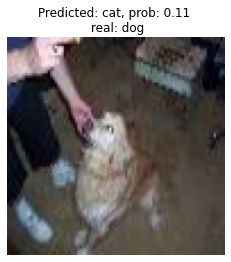

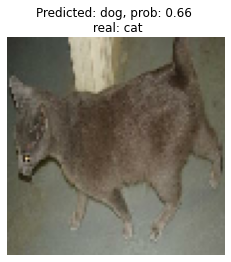

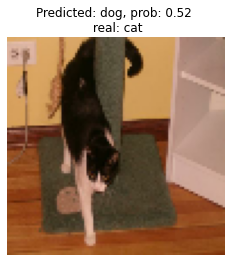

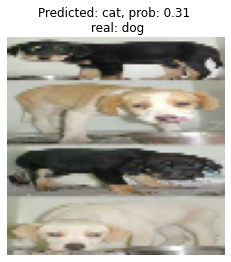

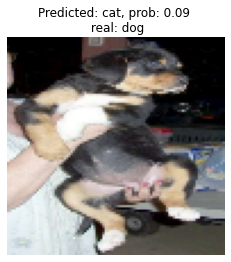

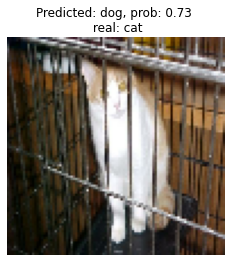

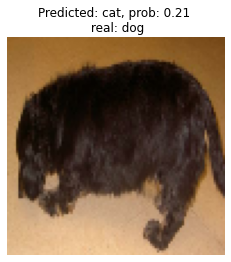

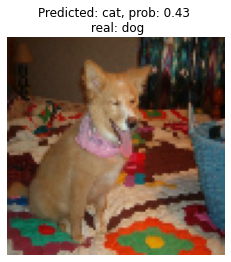

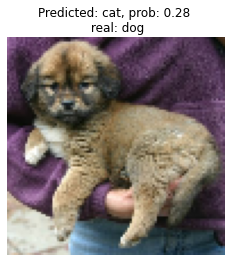

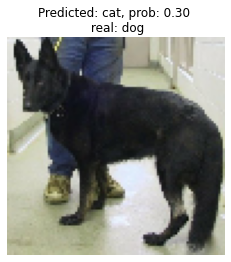

In [65]:
show_errors(test_ds, model_tl, class_names, n_images=10)

# Generalization

In [66]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

def predict_plot(image_path, model, class_names, image_size):
    image = read_image(image_path, image_size[:2])
    prob = model.predict(np.expand_dims(image, 0))[0][0]
    pred_class = class_names[(1.0 * (prob >= 0.5)).astype(np.int32)]
    plt.imshow(image)
    plt.title(
        'Predicted: {0}, prob: {1:.2f}'
        .format(pred_class, prob))
    plt.axis('off')
    plt.show()

57344/42082 [========================================] - 0s 1us/step
model 1


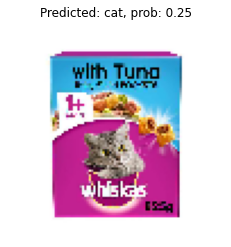

model 2


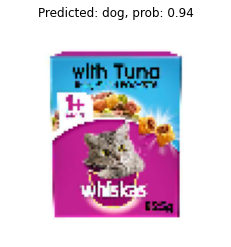

model 3


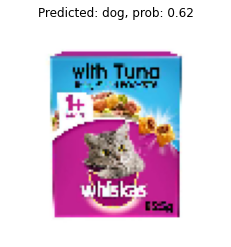

model tl


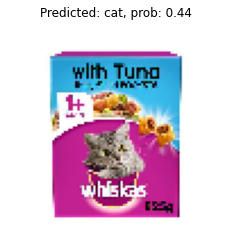

In [67]:
url = 'https://assets.sainsburys-groceries.co.uk/gol/6754229/1/640x640.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_1.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

40960/29181 [==========================================] - 0s 0us/step
model 1


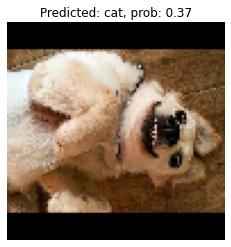

model 2


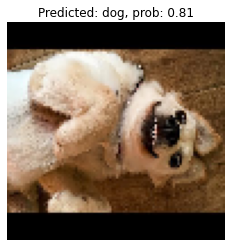

model 3


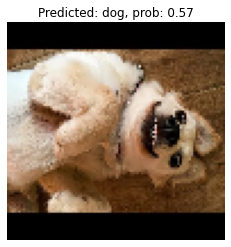

model tl


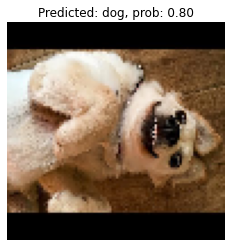

In [68]:
url = 'https://i.ytimg.com/vi/3dcli9i_pvA/hqdefault.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_2.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

40960/31182 [=======================================] - 0s 0us/step
model 1


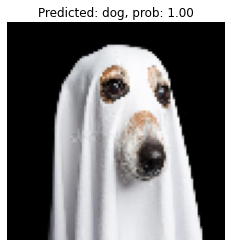

model 2


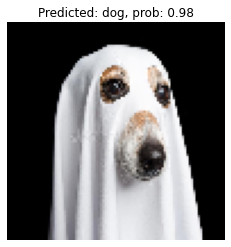

model 3


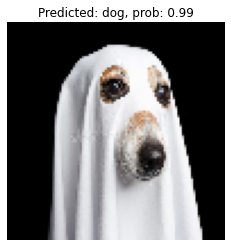

model tl


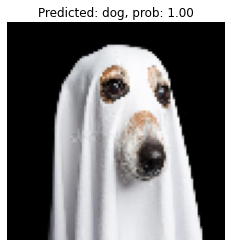

In [69]:
url = 'https://thumbs.dreamstime.com/b/halloween-ghost-portrait-funny-dog-black-background-adorable-pup-muzle-153863580.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_3.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

98304/82947 [===================================] - 1s 5us/step
model 1


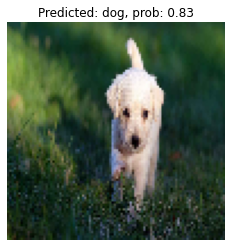

model 2


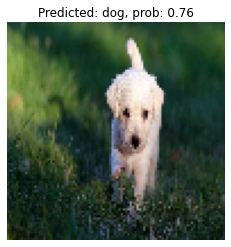

model 3


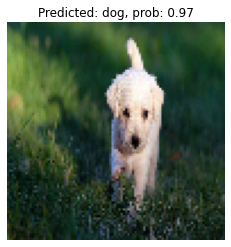

model tl


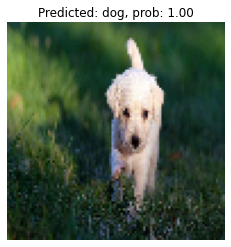

In [70]:
url = 'https://s1.eestatic.com/2021/06/24/curiosidades/mascotas/591454065_193121170_1706x960.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_4.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)